In [1]:
import torch
import torchaudio
import torchaudio.functional as tf

import copy
import matplotlib.pyplot as plt
from IPython.display import Audio as PyAudio, display
import numpy as np

from audio_utils import *

In [2]:
noise_data_path = r"data\noise-16k"
clean_audios_path = r"data\kaggle_train-clean-100"
clean_labels_path = r"data\8000_30_50_100_50_max"

# blacklist = ['7067-76048-0021']
blacklist = []

dataset = OpenSLRDataset(clean_audios_path, clean_labels_path, blacklist)
noise_files_paths = [os.path.join(noise_data_path, p) for p in os.listdir(noise_data_path) if p.endswith(".wav")]
print(f"Found {len(dataset)} clear audio files")
print(f"Found {len(noise_files_paths)} noise audio files")

Found 28539 clear audio files
Found 2000 noise audio files


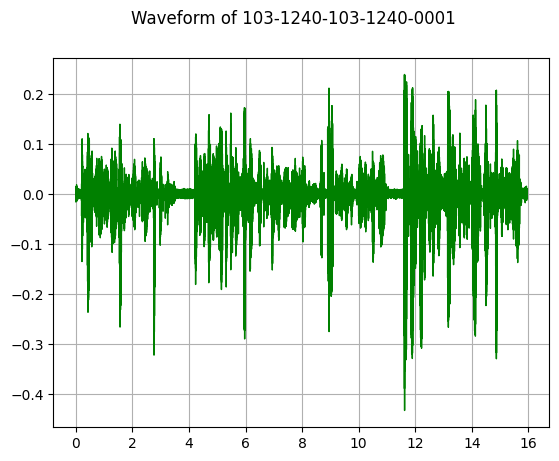

In [3]:
au, label = dataset[1]
au.player()
au.plot_waveform()

# Model

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
import random
from tqdm import tqdm

In [5]:
class WaveToMFCCConverter:
    def __init__(self, n_mfcc, sample_rate=8000, frame_duration_in_ms=None, win_length=None, hop_length=None):
        self.n_mfcc = n_mfcc

        if frame_duration_in_ms is not None:
            sample_count = torch.tensor(sample_rate * frame_duration_in_ms / 1000, dtype=torch.int)
            win_length = torch.pow(2, torch.ceil(torch.log2(sample_count)).to(torch.int)).to(torch.int).item()
        elif win_length is None:
            return
        win_length = int(win_length)

        if hop_length is None:
            hop_length = int(win_length // 2)
        hop_length = int(hop_length)

        mfcc_params = {
            "n_mfcc": n_mfcc,
            "sample_rate": sample_rate
        }
        mel_params = {
            "n_fft": win_length,
            "win_length": win_length,
            "hop_length": hop_length,
            "center": False
        }

        self.converter = torchaudio.transforms.MFCC(**mfcc_params, melkwargs=mel_params)

    def __call__(self, waveform):
        return self.converter(waveform).transpose(-1, -2)


In [6]:
class NoiceCollate:
    def __init__(self, noises, params, mfcc_converter):
        self.noises = noises
        self.params = params
        self.mfcc_converter = mfcc_converter
        
    def __call__(self, batch):
        inputs = []
        targets = []

        for au, label_txt in batch:
            au.resample(dataset.sample_rate)
            augmented_wave, _ = augment_sample(au, self.noises, **self.params)
            inp = self.mfcc_converter(augmented_wave)
            tar = torch.tensor([*map(float, label_txt)])
            if tar.size(-1) != inp.size(-2):
                print(tar.size(-1), inp.size(-2), au.name)
            inputs.append(inp)
            targets.append(tar)

        inp_dim_2 = max(i.size(1) for i in inputs)
        inputs_tens = torch.zeros([len(inputs), inp_dim_2, inputs[0].size(-1)])
        for i, inp in enumerate(inputs):
            inputs_tens[i, :inp.size(1), :] = inp

        tar_dim_1 = max(t.size(0) for t in targets)
        targets_tens = torch.zeros([len(targets), tar_dim_1, 1])
        for i, tar in enumerate(targets):
            targets_tens[i, :tar.size(0), 0] = tar

        return inputs_tens, targets_tens

In [7]:
class SimpleG(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super(SimpleG, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out)
        return out

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
dataloader = DataLoader(dataset, batch_size=2**7, shuffle=True)

In [10]:
input_size = 64
hidden_dim = 48

model = SimpleG(input_dim=input_size, hidden_dim=hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
bce = torch.nn.BCEWithLogitsLoss()
loss_history = []

In [12]:
do_epoches = 1
epoch_noise_count = 500
params = {
    "noise_count": 2,
    "noise_duration_range": (5, 10),
    "snr_db": 3
}

mfcc_converter = WaveToMFCCConverter(
    n_mfcc=input_size,
    sample_rate=dataset.sample_rate,
    win_length=dataset.label_window,
    hop_length=dataset.label_hop)

for epoch in range(do_epoches):
    noises = [AudioWorker(p, p.replace("\\", "__")) for p in random.sample(noise_files_paths, epoch_noise_count)]
    for noise in noises:
        noise.load()
        noise.resample(dataset.sample_rate)

    dataloader.collate_fn = NoiceCollate(noises, params, mfcc_converter)
    
    for batch_inputs, batch_targets in tqdm(dataloader, desc=f"epoch {epoch + 1}", disable=0):
        batch_inputs = batch_inputs.to(device)
        
        output = model(batch_inputs)

        batch_targets = batch_targets.to(device)
        
        loss = bce(output, batch_targets)
        loss_history.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()      
        
        pass

epoch 1: 100%|██████████| 223/223 [02:53<00:00,  1.29it/s]


In [13]:
loss_history

[0.7748904824256897,
 0.7576165795326233,
 0.7317082285881042,
 0.7055504322052002,
 0.6794459223747253,
 0.6587873101234436,
 0.6444272398948669,
 0.6324297189712524,
 0.6100291609764099,
 0.591878354549408,
 0.5787619948387146,
 0.5703639388084412,
 0.5610788464546204,
 0.54217928647995,
 0.5346516966819763,
 0.5281305313110352,
 0.5042917728424072,
 0.5011140704154968,
 0.500612735748291,
 0.4923960566520691,
 0.481025755405426,
 0.4673296809196472,
 0.47474485635757446,
 0.45688098669052124,
 0.4608227014541626,
 0.4438853859901428,
 0.4515669345855713,
 0.43471571803092957,
 0.4432123005390167,
 0.42134302854537964,
 0.424432635307312,
 0.4214964807033539,
 0.41932356357574463,
 0.4133169949054718,
 0.395318865776062,
 0.36965158581733704,
 0.3767175078392029,
 0.3789594769477844,
 0.36203330755233765,
 0.34787437319755554,
 0.3495461344718933,
 0.35035860538482666,
 0.3600684106349945,
 0.3302212655544281,
 0.33793124556541443,
 0.3167877495288849,
 0.32780805230140686,
 0.314928